In [1]:
import sys

import matplotlib.pyplot as plt
import json

import dysts
from dysts.datasets import *

from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *



# try:
#     from private.lyap import lyap_r, lyap_e, corr_dim
# except:
#     from nolds import lyap_r, lyap_e, corr_dim


%load_ext autoreload
%autoreload 2

In [6]:



# from darts.models import ExponentialSmoothing

# model = ExponentialSmoothing()
# model.fit(train)
# prediction = model.predict(len(val))

In [6]:
import darts.models

Importing plotly failed. Interactive plots will not work.


In [106]:
hyperparameters = {"lags": 10, "lags_exog": 10}
darts.models.RandomForest(**hyperparameters)

In [185]:

import darts
import darts.models

all_models = [
        'ARIMA',
        'AutoARIMA',
#         'EnsembleModel',
        'ExponentialSmoothing',
        'FFT',
        'FourTheta',
        'LinearRegressionModel',
        'NBEATSModel',
        'NaiveDrift',
        'NaiveEnsembleModel',
        'NaiveMean',
        'NaiveSeasonal',
        'Prophet',
        'RNNModel',
        'RandomForest',
        'TCNModel',
        'Theta',
        'TransformerModel',
        'VARIMA']

all_models = [
        ('AutoARIMA', {}),
        ('ExponentialSmoothing', {}),
        ('FFT', {}),
        ('FourTheta', {"season_mode": darts.utils.utils.SeasonalityMode.ADDITIVE}),
        ('LinearRegressionModel', {"lags": 10}),
        ('NaiveDrift', {}),
        ('NaiveMean', {}),
        ('NaiveSeasonal', {}),
        ('NBEATSModel', {"input_chunk_length": 40, "output_chunk_length": 1}),
        ('Prophet', {}),
        ('RandomForest', {"lags": 10, "lags_exog": None}),
        ('TCNModel', {"input_chunk_length": 40, "output_chunk_length": 1}),
        ('Theta', {"season_mode": darts.utils.utils.SeasonalityMode.ADDITIVE})
#         ('VARIMA', {})
]



train_data = load_continuous(subsets="train").to_array()[0]
test_data = load_continuous(subsets="test").to_array()[0]

split_point = int(0.8 * len(train_data))

all_predictions = list()
for model_name, hyperparameters in all_models:
    print(model_name)
    model = getattr(darts.models, model_name)(**hyperparameters)
    
    train_df = TimeSeries.from_dataframe(pd.DataFrame(train_data))
    train, val = train_df.split_after(split_point)
    model.fit(train)
    prediction = model.predict(len(val))
    all_predictions.append(np.squeeze(prediction.values()))

AutoARIMA
ExponentialSmoothing
FFT


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
[2021-06-10 08:48:21,877] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 67
[2021-06-10 08:48:21,877] INFO | darts.models.theta | FourTheta model inferred seasonality of training series: 67
INFO:darts.models.theta:FourTheta model inferred seasonality of training series: 67
[2021-06-10 08:48:21,888] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model
[2021-06-10 08:48:21,888] WARNING | darts.models.theta | Time series has negative values. Fallback to additive and linear model


FourTheta
LinearRegressionModel


[2021-06-10 08:48:24,600] INFO | darts.models.torch_forecasting_model | Train dataset contains 761 samples.
[2021-06-10 08:48:24,600] INFO | darts.models.torch_forecasting_model | Train dataset contains 761 samples.
INFO:darts.models.torch_forecasting_model:Train dataset contains 761 samples.


NaiveDrift
NaiveMean
NaiveSeasonal
NBEATSModel


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Prophet
RandomForest


[2021-06-10 08:52:03,852] INFO | darts.models.torch_forecasting_model | Train dataset contains 761 samples.
[2021-06-10 08:52:03,852] INFO | darts.models.torch_forecasting_model | Train dataset contains 761 samples.
INFO:darts.models.torch_forecasting_model:Train dataset contains 761 samples.
[2021-06-10 08:52:03,872] INFO | darts.models.tcn_model | Number of layers chosen: 4
[2021-06-10 08:52:03,872] INFO | darts.models.tcn_model | Number of layers chosen: 4
INFO:darts.models.tcn_model:Number of layers chosen: 4


TCNModel


[2021-06-10 08:52:17,096] INFO | darts.models.theta | Theta model inferred seasonality of training series: 67
[2021-06-10 08:52:17,096] INFO | darts.models.theta | Theta model inferred seasonality of training series: 67
INFO:darts.models.theta:Theta model inferred seasonality of training series: 67


Theta


/Users/williamgilpin/miniconda3/envs/nn/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [ ]:

names = 
models =
metrics =
benchmark_forecasts = pd.DataFrame

In [ ]:
ModelMode.ADDITIVE

In [166]:
?darts.models.NBEATSModel

Init signature:
darts.models.NBEATSModel(
    input_chunk_length: int,
    output_chunk_length: int,
    generic_architecture: bool = True,
    num_stacks: int = 30,
    num_blocks: int = 1,
    num_layers: int = 4,
    layer_widths: Union[int, List[int]] = 256,
    expansion_coefficient_dim: int = 5,
    trend_polynomial_degree: int = 2,
    **kwargs,
)
Docstring:     
The base class for "global" forecasting models, handling several time series and optional covariates.

All implementations have to implement the `fit()` and `predict()` methods defined below.
The `fit()` method is meant to train the model on one or several training time series, along with optional
covariates. Note that not all global models support covariates.

If `fit()` has been called with only one training series as argument, then calling `predict()` will
forecast the future of this series. Otherwise, the user has to provide to `predict()` the series they want
to forecast, as well as covariates if needed.
Init docst

In [68]:
?darts.utils.utils.SeasonalityMode 

Init signature:
darts.utils.utils.SeasonalityMode(
    value,
    names=None,
    *,
    module=None,
    qualname=None,
    type=None,
    start=1,
)
Docstring:      An enumeration.
File:           ~/miniconda3/envs/nn/lib/python3.8/site-packages/darts/utils/utils.py
Type:           EnumMeta
Subclasses:     


In [95]:
all_predictions[0]

IndexError: list index out of range

In [62]:
len(val)

199

In [175]:
 train_data[split_point:].shape

(200,)

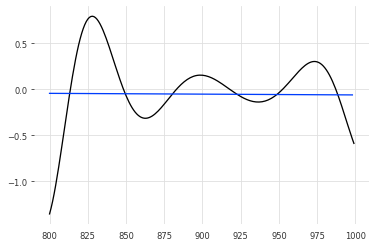

In [184]:
plt.plot(np.arange(split_point, 1000), train_data[split_point:])
plt.plot(np.arange(split_point, 999), all_predictions[0])

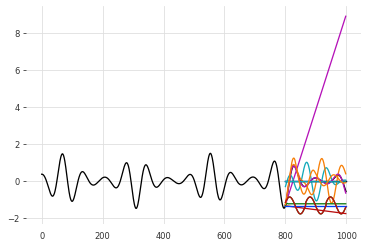

In [186]:
plt.plot(np.arange(1000), train_data)
# plt.plot(all_predictions)

for pred in all_predictions:
    plt.plot(np.arange(split_point, 999), pred)
    


In [34]:
?train_df.split_after

Signature:
train_df.split_after(
    split_point: Union[pandas._libs.tslibs.timestamps.Timestamp, float, int],
) -> Tuple[ForwardRef('TimeSeries'), ForwardRef('TimeSeries')]
Docstring:
Splits the TimeSeries in two, after a provided `split_point`.

Parameters
----------
split_point
    A timestamp, float or integer. If float, represents the proportion of the dataset to include in the
    first TimeSeries (must be between 0.0 and 1.0). If integer, represents the index position after
    which the split is performed. If timestamp, it will be contained in the first TimeSeries, but not
    in the second one. The timestamp may not appear in the original TimeSeries index.

Returns
-------
Tuple[TimeSeries, TimeSeries]
    A tuple of two time series. The first time series contains the first samples up to the `split_point`,
    and the second contains the remaining ones.
File:      ~/miniconda3/envs/nn/lib/python3.8/site-packages/darts/timeseries.py
Type:      method


In [29]:
pd.DataFrame(np.vstack([np.arange(len(train_data)), train_data]).T, columns=["time", "vals"])


,0,1
0,0.0,0.353756
1,1.0,0.353819
2,2.0,0.350929
3,3.0,0.344973
4,4.0,0.335860
...,...,...
995,995.0,-0.389878
996,996.0,-0.441711
997,997.0,-0.492419
998,998.0,-0.541439


In [9]:
from darts import TimeSeries
import pandas as pd
# series = TimeSeries.from_dataframe(df, 'Month', '#Passengers')

                                      0
1970-01-01 00:00:00.000000000  0.353756
1970-01-01 00:00:00.000000001  0.353819
1970-01-01 00:00:00.000000002  0.350929
1970-01-01 00:00:00.000000003  0.344973
1970-01-01 00:00:00.000000004  0.335860
...                                 ...
1970-01-01 00:00:00.000000995 -0.389878
1970-01-01 00:00:00.000000996 -0.441711
1970-01-01 00:00:00.000000997 -0.492419
1970-01-01 00:00:00.000000998 -0.541439
1970-01-01 00:00:00.000000999 -0.588207

[1000 rows x 1 columns]
Freq: N

In [2]:
load_continuous(subsets="train").to_array().shape

(131, 1000)

In [3]:
load_continuous(subsets="test").to_array().shape

(131, 200)

In [4]:
load_continuous(subsets="val").to_array().shape

(131, 200)